Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [330]:
import pandas as pd
import json
import numpy as np
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import tree, ensemble
from sklearn.linear_model import Ridge

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score


## 1. Exploratoray Data Analaysis  

Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [115]:
#read json file as dataframe
login_df = pd.read_json('logins.json',convert_dates=True)


In [116]:
#check the missing data
login_df['login_time'].isnull().sum()

0

In [117]:
login_df.sort_values('login_time', inplace=True)
login_df.head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


In [118]:
#groypby 15min
login_df['loginCount']= 1
login_index=login_df.set_index('login_time')
login=login_index.resample('15T').sum()
#login = login.reset_index()
login.head()


,loginCount
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


In [119]:
login.isnull().sum().sum()

407

In [120]:
login = login.fillna(0)

In [121]:
login.isnull().sum()

loginCount    407
dtype: int64

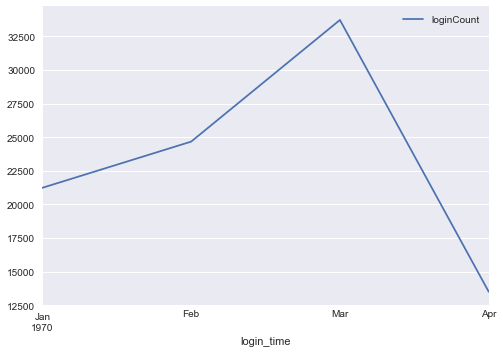

In [122]:
#show the daily login for each month
login.resample('M').sum().plot()
plt.show()

march has the highest login count and april has the lowest number of logins

In [123]:
login_jan = login['1970-01']
login_feb = login['1970-02']
login_mar= login['1970-03']
login_apr = login['1970-04']


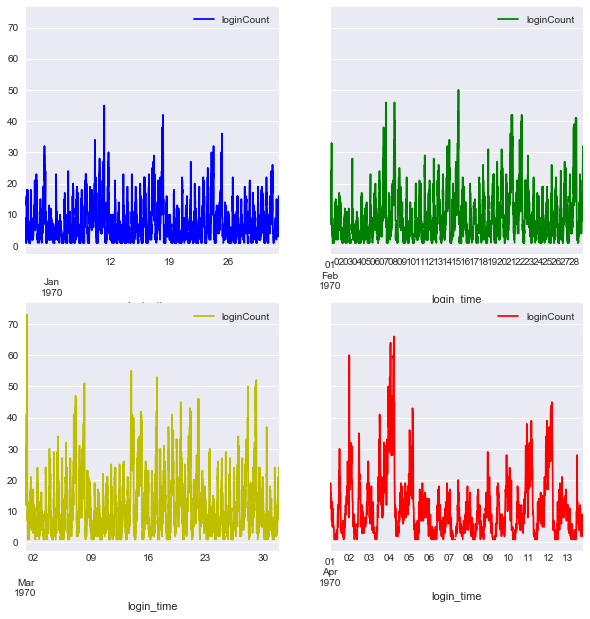

In [124]:
# visualize the data pattern
fig , ax1 = plt.subplots(nrows=2, ncols=2, figsize=(10,10),sharey=True)
login_jan.plot(ax=ax1[0,0],color='b')
login_feb.plot(ax=ax1[0,1],color='g')
login_mar.plot(ax=ax1[1,0],color='y')
login_apr.plot(ax=ax1[1,1],color='r')
plt.show()

Feb i sthe busyiest time of the year

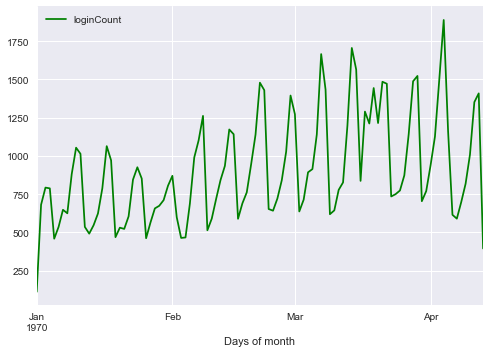

In [125]:
#Daily analysis
login.resample('D').sum().plot(color='g')
plt.xlabel('Days of month')
plt.show()

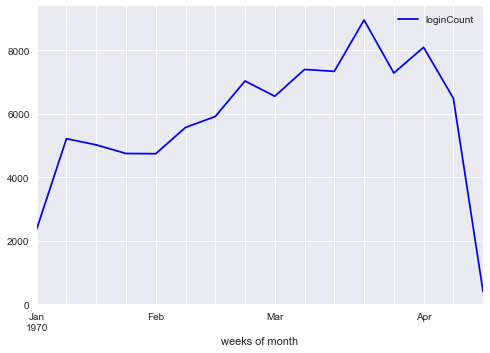

In [126]:
#weekly analysis
login.resample('W').sum().plot(color='b')
plt.xlabel('weeks of month')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.show()

In [127]:
# Extract hours and wekdays
login_df['hour'] = login_df['login_time'].dt.hour
login_df['wdays'] = login_df['login_time'].dt.weekday_name
login_df['month'] = login_df['login_time'].dt.month
login_df. head()

,login_time,loginCount,hour,wdays,month
6,1970-01-01 20:12:16,1,20,Thursday,1
0,1970-01-01 20:13:18,1,20,Thursday,1
1,1970-01-01 20:16:10,1,20,Thursday,1
3,1970-01-01 20:16:36,1,20,Thursday,1
2,1970-01-01 20:16:37,1,20,Thursday,1


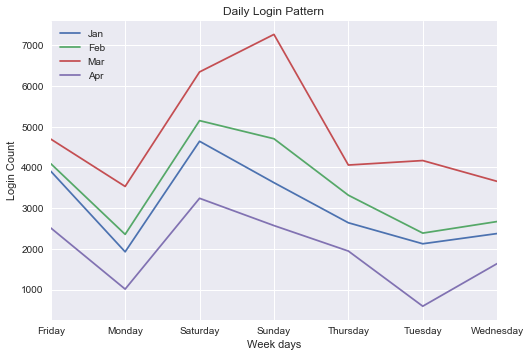

In [128]:
login_df[login_df.month==1].groupby('wdays')['loginCount'].sum().plot(label='Jan')
login_df[login_df.month==2].groupby('wdays')['loginCount'].sum().plot(label='Feb')
login_df[login_df.month==3].groupby('wdays')['loginCount'].sum().plot(label='Mar')
login_df[login_df.month==4].groupby('wdays')['loginCount'].sum().plot(label='Apr')
plt.xlabel('Week days')
plt.ylabel('Login Count')
plt.legend(loc='upper left')
plt.title('Daily Login Pattern')
plt.show()

In every month except march saturday has the highest number of login numbers.

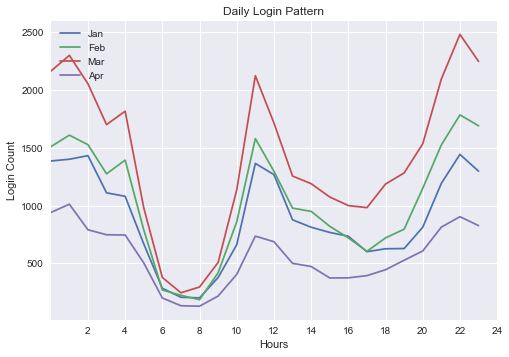

In [129]:
login_df[login_df.month==1].groupby('hour')['loginCount'].sum().plot(label='Jan')
login_df[login_df.month==2].groupby('hour')['loginCount'].sum().plot(label='Feb')
login_df[login_df.month==3].groupby('hour')['loginCount'].sum().plot(label='Mar')
login_df[login_df.month==4].groupby('hour')['loginCount'].sum().plot(label='Apr')
plt.xlabel('Hours')
plt.ylabel('Login Count')
plt.xticks([2,4,6,8,10,12,14,16,18,20,22,24])
plt.legend(loc='upper left')
plt.title('Daily Login Pattern')
plt.show()

mostly the highest number of login count during a day is at 10pm-2am a d between 6 to 8 am is the lowest login time.

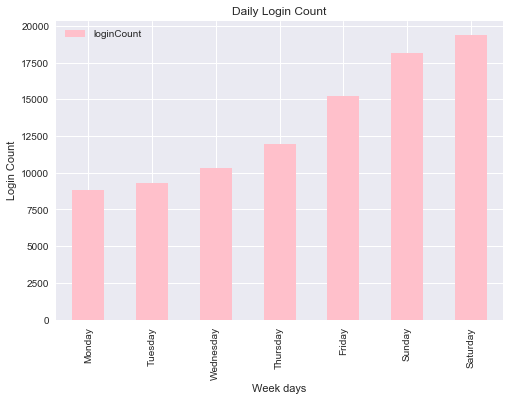

In [130]:
login_df.groupby('wdays')['loginCount'].sum().sort_values().plot(kind='bar', color='pink')
plt.xlabel('Week days')
plt.ylabel('Login Count')
plt.legend(loc='upper left')
plt.title('Daily Login Count')
plt.show()

In [131]:
hours = login_df
hours = hours[['loginCount', 'hour']]
hours = hours.groupby('hour').sum().reset_index()
hours.head()


,hour,loginCount
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


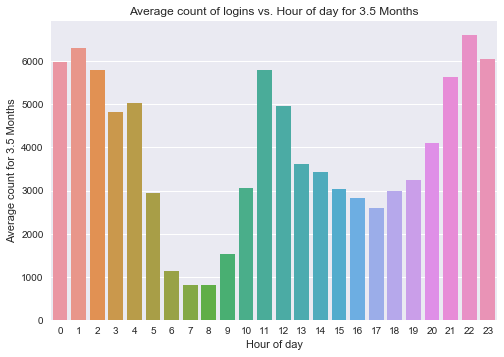

In [132]:
sns.barplot(x='hour', y='loginCount', data=hours)
plt.ylabel('Average count for 3.5 Months')
plt.xlabel('Hour of day')
plt.title('Average count of logins vs. Hour of day for 3.5 Months')
plt.show()

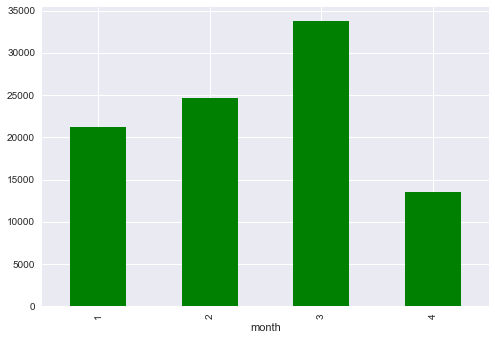

In [133]:
login_df.groupby('month')['loginCount'].sum().plot(kind='bar', color='g')
plt.show()

### Conclusion of part 1:

Amount of user-logins increase and peak torwards the weekend and saturday has the highest number of logins.

Amount of user-logins increase during day between 11 am to noon and during late-night  from 9 pm to 4 am.

Amount of user-logins increase in month March.



## 2 ‑ Experiment and metrics design  

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

#### Solution:
    
For measure of success in this experience I would use A/B testing:  

A/B testing is a fantastic method for figuring out the best strategy for comparing the effectiveness of the proposed change. W

In this experiment I would like to test which way has more profit to business:  

1-Drivers work in both cities with reimbursing toll cost  

2-Drivers work in specific cities  

For this matter I would put half of the drivers for the new test so half of drivers work in both cities with reimbursing toll cost for few month and leave the other half. We test the followings:
In order to increase profit, the additional income brought in during the experiment must outweigh the toll cost reimbursements. We would use the key metric of profit after reimbursement.
 After a few months, we compare the profit made after reimbursement of toll costs. A more robust study could last a year. All driver partners are included in the study and the profit made for the year is compared to the previous years with time series analysis.

After getting our results, we would use a t-test to test for significance (p = 0.05) between each group.

we can run the hypothesis as  

H0--> Drivers work in both cities will reimburing cost is profitable and added more customers.    

H1--> Drivers work in both cities will reimburing cost is not profitable and does not added more customers.  
 
  would then calculate the z-score for the customer activity after implementation of the reimbursement
Then using a 95% confidence interval I would determine whether or not the z-score falls in that range, and observe whether or not the null hypothesis can be rejected
If it can be rejected then I would recommend that the company continue to reimburse toll costs and continue to observe the number of times drivers are crossing the bridge to make sure company money is well spent


## Part 3 ‑ Predictive modeling   

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [267]:
#load Json data to dataframe
ultimate_json=open('ultimate_data_challenge.json','r')
ultimate_df=pd.DataFrame(json.loads(ultimate_json.read()))
ultimate_df.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [268]:
ultimate_df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

In [269]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [270]:
ultimate_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


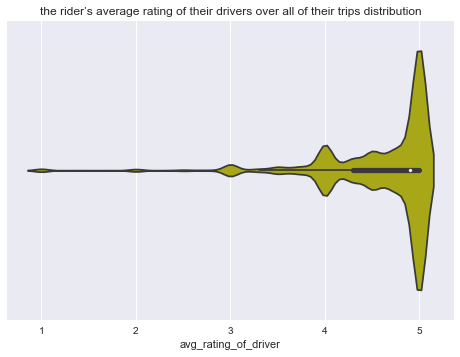

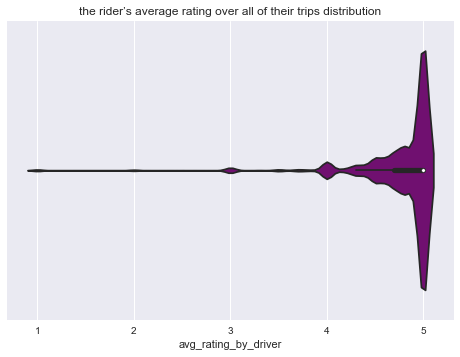

In [271]:
sns.violinplot(ultimate_df.avg_rating_of_driver,color='y')
plt.title('the rider’s average rating of their drivers over all of their trips distribution')
plt.show()
sns.violinplot(ultimate_df.avg_rating_by_driver ,color='purple')
plt.title('the rider’s average rating over all of their trips distribution')
plt.show()

Probably we would like to check for the central tendency of the data and replace the null accordingly. 
It is visible from the seaborne plot that data was not distribute normally. Therefore picking median to fill remaining values is a good choice.

In [272]:
for col in ['avg_rating_of_driver', 'avg_rating_by_driver']:
    ultimate_df[col] = Imputer(missing_values="NaN",strategy='mean').fit_transform(
                                    ultimate_df[col].values.reshape(-1, 1))

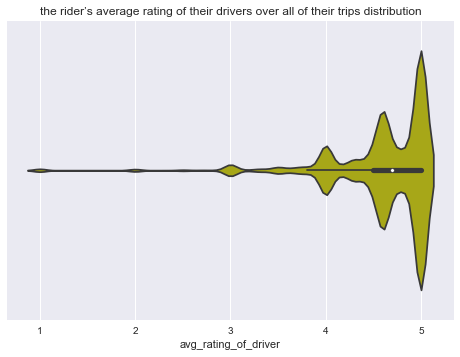

In [273]:
sns.violinplot(ultimate_df.avg_rating_of_driver,color='y')
plt.title('the rider’s average rating of their drivers over all of their trips distribution')
plt.show()

In [274]:
ultimate_df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [275]:
#So for phone misising values we can use median which will be iphone.
ultimate_df.phone.fillna('iPhone',inplace=True)

In [276]:
ultimate_df.isnull().sum().sum()

0

### EDA

In [277]:
ultimate_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


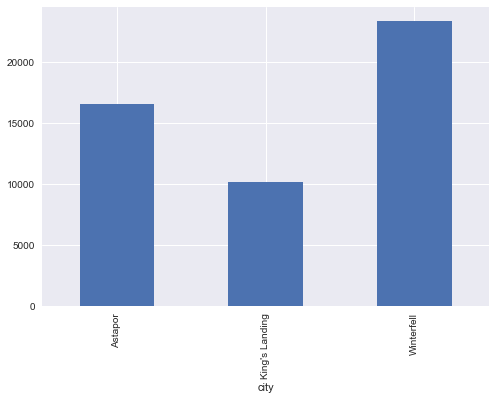

In [278]:
ultimate_df.groupby('city').size().plot(kind='bar')
plt.show()

Most of users are from Winterfall

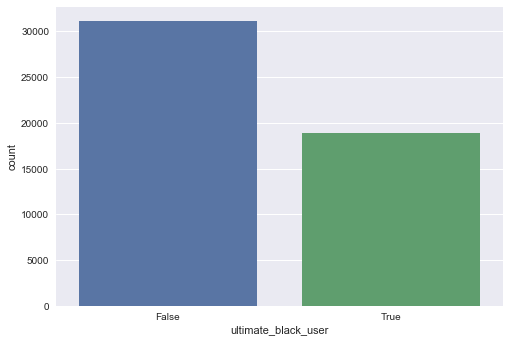

In [279]:
sns.countplot(ultimate_df.ultimate_black_user)
plt.show()

In [280]:
# Change the column Data types in Required Format
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])
type(ultimate_df['signup_date'][0]), type(ultimate_df['last_trip_date'][0])

(pandas._libs.tslib.Timestamp, pandas._libs.tslib.Timestamp)

In [281]:
last_day = max(ultimate_df['last_trip_date'])
days_diff = [last_day - datetime.timedelta(days=x) for x in range(0, 30)]
ultimate_df['retained_user'] = ultimate_df['last_trip_date'].map(lambda x: int(x in days_diff))

In [282]:
active = ultimate_df[ultimate_df['retained_user'] == 1]
non_active_users = ultimate_df[ultimate_df['retained_user'] == 0]
percent_active = len(active_users) / len(ultimate_df)
print('Percentage of Retained users: {0}'.format(percent_active))

Percentage of Retained users: 0.3662


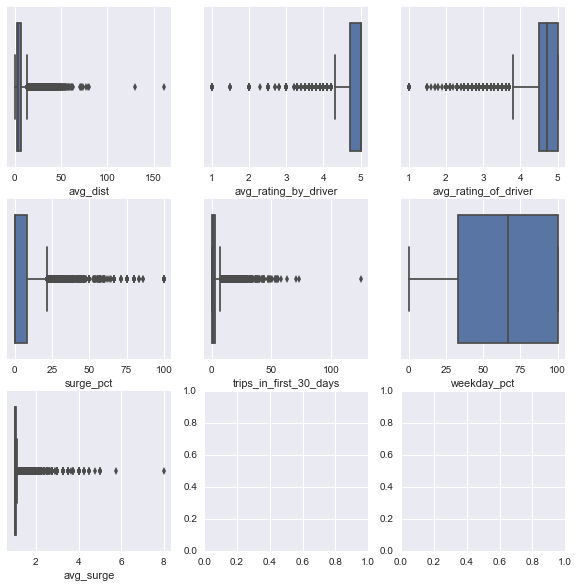

In [283]:
#outlier

fig , ax1 = plt.subplots(nrows=3, ncols=3,figsize=(10,10) )
sns.boxplot('avg_dist', data=ultimate_df, ax=ax1[0,0])
sns.boxplot('avg_rating_by_driver', data=ultimate_df, ax=ax1[0,1])
sns.boxplot('avg_rating_of_driver', data=ultimate_df, ax=ax1[0,2])
sns.boxplot('surge_pct', data=ultimate_df, ax=ax1[1,0])
sns.boxplot('trips_in_first_30_days',data=ultimate_df, ax=ax1[1,1])
sns.boxplot('weekday_pct', data=ultimate_df, ax=ax1[1,2])
sns.boxplot('avg_surge', data=ultimate_df, ax=ax1[2,0])
plt.show()

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [284]:
ultimate_df['active_user'] = ((ultimate_df['last_trip_date'] - ultimate_df['signup_date']) / np.timedelta64(1, 'M')).\
        map(lambda x: 'active' if x > 5 else 'inactive')

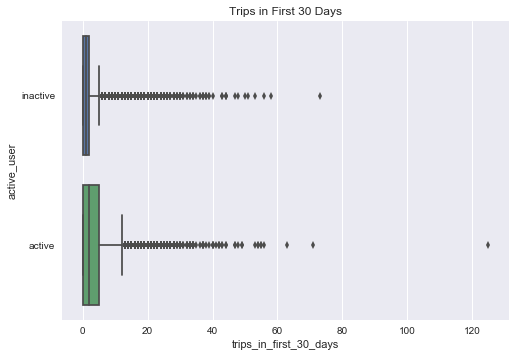

In [285]:
sns.boxplot(x='trips_in_first_30_days', y='active_user', data=ultimate_df)
plt.title('Trips in First 30 Days')
plt.show()

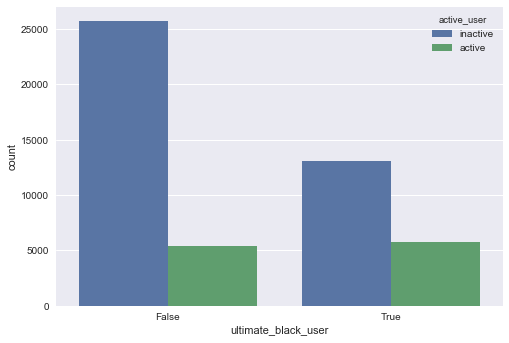

In [286]:
sns.countplot(x='ultimate_black_user',hue='active_user',data=ultimate_df)
plt.show()

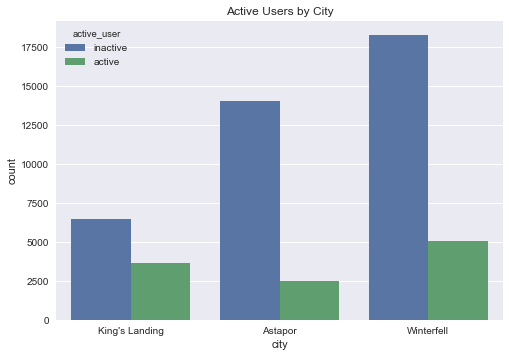

In [287]:
sns.countplot(x='city', hue='active_user', data=ultimate_df)
plt.title('Active Users by City')
plt.show()

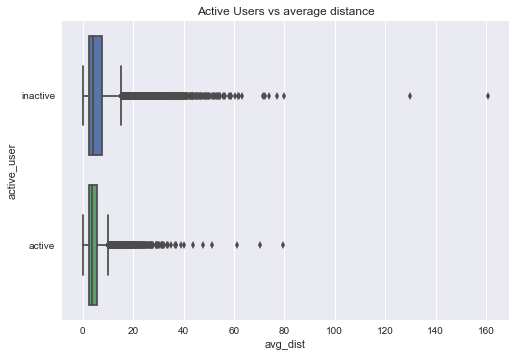

In [288]:
sns.boxplot(x='avg_dist',  y='active_user', data=ultimate_df)
plt.title('Active Users vs average distance')
plt.show()

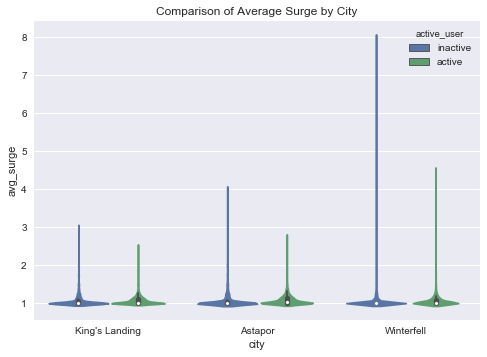

In [289]:
sns.violinplot(x="city", y="avg_surge", hue='active_user', data=ultimate_df)
plt.title('Comparison of Average Surge by City')
plt.show()

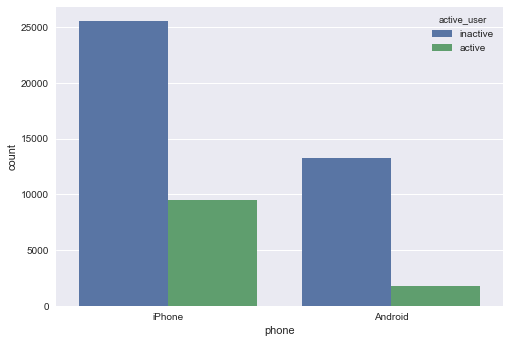

In [290]:
sns.countplot(x='phone',hue='active_user',data=ultimate_df)
plt.show()

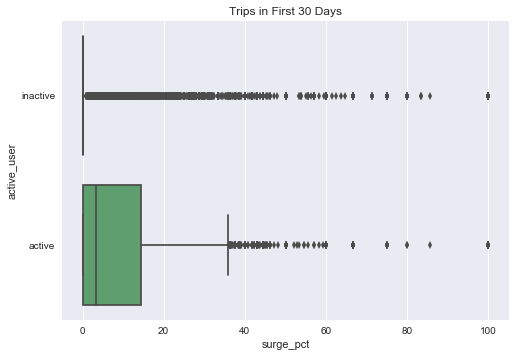

In [291]:
#reduce data using outliers 
sns.boxplot(x='surge_pct', y='active_user', data=ultimate_df)
plt.title('Trips in First 30 Days')
plt.show()

In [292]:
sample = ultimate_df.drop(ultimate_df[(ultimate_df.surge_pct > 99)|(ultimate_df.trips_in_first_30_days>100)].index)
sample.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained_user,active_user
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1,inactive
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0,inactive
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0,inactive
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1,active
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0,inactive


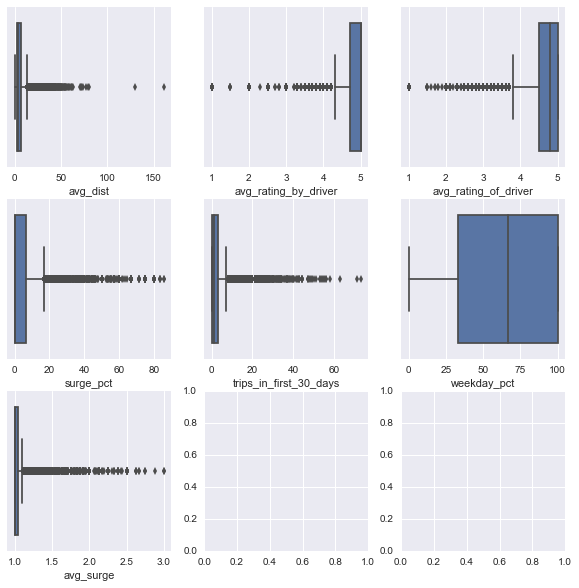

In [293]:
fig , ax1 = plt.subplots(nrows=3, ncols=3,figsize=(10,10) )
sns.boxplot('avg_dist', data=sample, ax=ax1[0,0])
sns.boxplot('avg_rating_by_driver', data=sample, ax=ax1[0,1])
sns.boxplot('avg_rating_of_driver', data=sample, ax=ax1[0,2])
sns.boxplot('surge_pct', data=sample, ax=ax1[1,0])
sns.boxplot('trips_in_first_30_days',data=sample, ax=ax1[1,1])
sns.boxplot('weekday_pct', data=sample, ax=ax1[1,2])
sns.boxplot('avg_surge', data=sample, ax=ax1[2,0])
plt.show()

In [294]:
print(len(sample))
print(len(ultimate_df))

48583
50000


### Conclusion of EDA

36% of the observed users were retained  

Most users appear to be in the Winterfell area and Winterfell's deactive users have the highest average surge

active users used more rides in their first 30 days of enrolment  


#### Features  

First we will drop repetitive columns and columns that don't have much value for prediction. These columns are the last trip date, signup date, surge percentage, phone, and ultimate black status. I also combined the average rating by driver and average rating of driver into one column by taking the average of the two.

It appears that our features seem to have mostly skewed distributions, scaling will most likely be necessary for our modeling process.

Looking at a correlation analysis of our features, it appears that there is not a strong correlation between any two features.

In [298]:
sample=sample.replace(['active', 'inactive'], [1, 0]) 

sample=sample.replace(["King's Landing", 'Astapor', 'Winterfell'],[1,2,3])

In [299]:
sample.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained_user,active_user
avg_dist,1.000000,0.081458,0.029829,-0.112657,0.009522,-0.139371,-0.141110,0.029755,0.102114,-0.093028,-0.092475
avg_rating_by_driver,0.081458,1.000000,0.102867,0.002657,-0.111103,0.007385,-0.039151,0.011963,0.023500,-0.026478,-0.021849
avg_rating_of_driver,0.029829,0.102867,1.000000,-0.019135,-0.105873,-0.001681,-0.012219,-0.001994,0.012722,-0.011033,-0.008312
avg_surge,-0.112657,0.002657,-0.019135,1.000000,-0.041200,0.825053,0.080604,-0.028271,-0.094969,0.084546,0.078203
city,0.009522,-0.111103,-0.105873,-0.041200,1.000000,-0.093536,0.012682,-0.055292,-0.027332,-0.171615,-0.096984
surge_pct,-0.139371,0.007385,-0.001681,0.825053,-0.093536,1.000000,0.100997,-0.044452,-0.111256,0.115869,0.104348
trips_in_first_30_days,-0.141110,-0.039151,-0.012219,0.080604,0.012682,0.100997,1.000000,0.106601,0.044883,0.214073,0.199612
ultimate_black_user,0.029755,0.011963,-0.001994,-0.028271,-0.055292,-0.044452,0.106601,1.000000,0.025075,0.203464,0.148924
weekday_pct,0.102114,0.023500,0.012722,-0.094969,-0.027332,-0.111256,0.044883,0.025075,1.000000,0.019562,-0.004040
retained_user,-0.093028,-0.026478,-0.011033,0.084546,-0.171615,0.115869,0.214073,0.203464,0.019562,1.000000,0.705385


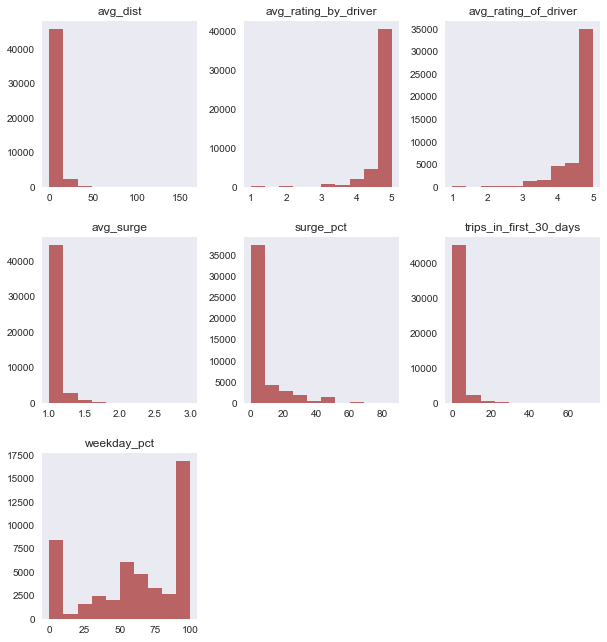

In [246]:
qty_related = ['avg_dist', 'surge_pct',
                   'avg_surge','trips_in_first_30_days','avg_rating_by_driver','avg_rating_of_driver']
sample[qty_related].hist(figsize=(10,11), alpha=0.7, color='brown', grid=False)
plt.show()

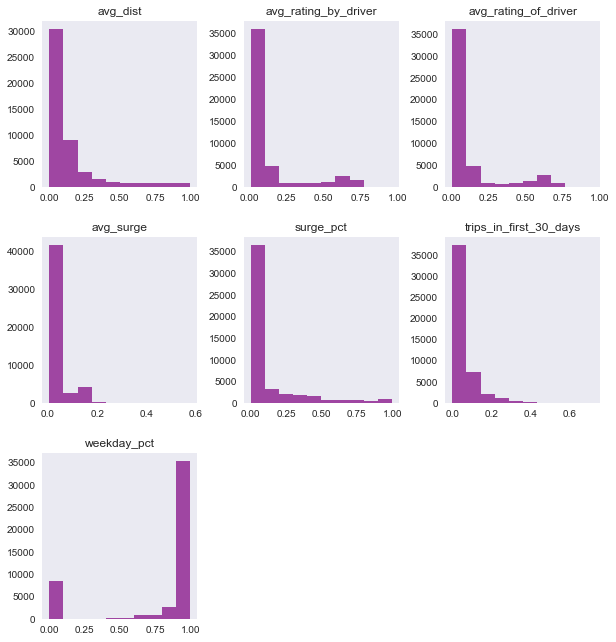

In [247]:
sample[qty_related] = normalize(sample[qty_related], axis=1)
sample[qty_related].hist(figsize=(10,11), alpha=0.7, color='purple', grid=False)
plt.show()

In [303]:
#drop some columns that they dont have any efefcts on prediction
sample=sample.drop(['phone','weekday_pct','avg_rating_of_driver','avg_dist','city','avg_rating_by_driver',
                    'signup_date','retained_user'],axis=1)

In [307]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48583 entries, 0 to 49999
Data columns (total 6 columns):
avg_surge                 48583 non-null float64
last_trip_date            48583 non-null datetime64[ns]
surge_pct                 48583 non-null float64
trips_in_first_30_days    48583 non-null int64
ultimate_black_user       48583 non-null bool
active_user               48583 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2)
memory usage: 3.5 MB


In [323]:
print ('Activer user percentage in the sample dataset:', (len(sample[sample['active_user']==1])/len(sample))*100,'%')

Activer user percentage in the sample dataset: 22.81250643229113 %


### Modeling

This is a binary classification problem, we will start with a few standard binary classification algorithms: 
    logistic regression, K-Nearest Neighbors, and Random Forest classifier.
    The target class is very imbalance.Only 22% of the observed
data contains active users. As far as our prediction goes, guessing that a user will not
be active in their 6th month will be correct 78% percent of the time. Due to this target class imbalance, accuracy will
probably not be the best metric to evaluate model performance. A better metric to use for this problem would be observing 
the receiving operating characteristic (ROC) curve. This curve plots the the fraction of true positives out of the positives 
(TPR = true positive rate) vs. 
the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings.

####    1.Logestic Regression  

In [347]:
target=['active_user']
features=['avg_surge',
'surge_pct','trips_in_first_30_days',
'ultimate_black_user']


In [348]:
X = sample[features]
y = sample['active_user'].values

In [349]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [350]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.6):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [351]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(random_state=None), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           sample, features, 'active_user',1)



C:\Users\Hedi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 10}
Accuracy on training data: 0.78
Accuracy on test data:     0.77


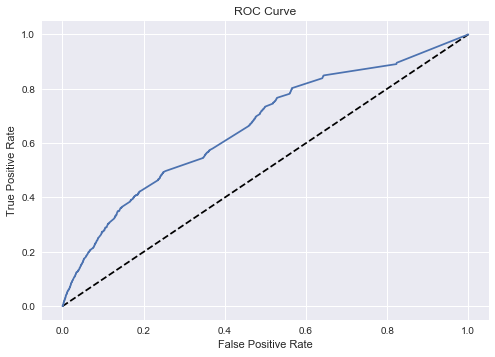

In [352]:
#ROC curves provide a way to visually evaluate models
# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf_l.predict_proba(Xtest_l)[:,1]
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(ytest_l, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [353]:
y_pred_prob = clf_l.predict_proba(Xtest_l)[:,1]
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(ytest_l, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(clf_l, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))



AUC: 0.6598995150708022
AUC scores computed using 5-fold cross-validation: [ 0.65181741  0.67356788  0.66031511  0.6562086   0.67479486]


In [354]:
print(classification_report(ytest_l, (y_pred_prob).astype(int)))

             precision    recall  f1-score   support

          0       0.77      1.00      0.87     14992
          1       0.00      0.00      0.00      4442

avg / total       0.60      0.77      0.67     19434



C:\Users\Hedi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [355]:
print(clf_l.coef_)

[[-0.30423765  0.01989945  0.10851494  0.65076775]]


#### 2.Random Forest

In [356]:
target=['active_user']
features=['avg_surge',
'surge_pct','trips_in_first_30_days',
'ultimate_black_user']

In [357]:
X = sample[features]
y = sample['active_user'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=42)

In [358]:
forest = ensemble.RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2)
forest.fit(Xtrain, ytrain)
# Print the score of the fitted random forest
print(forest.score(Xtrain, ytrain))

# Compute predictions on our test set features then print the length of the prediction vector
pred_forest =forest.predict(Xtest)
print(len(pred_forest))
print(classification_report(ytest, pred_forest))


0.806720526939
9717
             precision    recall  f1-score   support

          0       0.81      0.94      0.87      7483
          1       0.59      0.28      0.38      2234

avg / total       0.76      0.79      0.76      9717



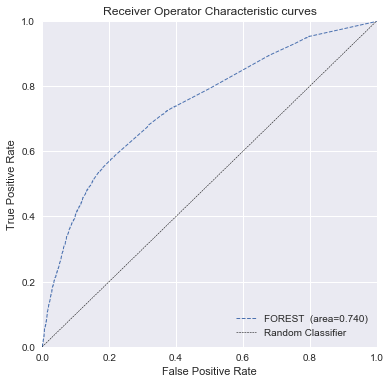

In [359]:
def roc_auc_plot(ytrue, pred_forest, label=' ', l='-', lw=1.0):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(ytrue, pred_forest[:,1])
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (area=%.3f)"%(label,roc_auc_score(ytrue, pred_forest[:,1])))

f, ax = plt.subplots(figsize=(6,6))

roc_auc_plot(ytest,forest.predict_proba(Xtest),label='FOREST ',l='--')


ax.plot([0,1], [0,1], color='k', linewidth=0.5, linestyle='--', 
        label='Random Classifier')    
ax.legend(loc="lower right")    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Receiver Operator Characteristic curves')
sns.despine()
plt.show()


In [360]:
#Area under ROC:Large area under ROC curve the better our model is(AUC)
#Compute AUC
# If the AUC is greater than 0.5, the model is better than random guessing
# Compute predicted probabilities: y_pred_prob
y_pred_prob = forest.predict_proba(Xtest)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(ytest, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(forest, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.7400863024526736
AUC scores computed using 5-fold cross-validation: [ 0.73066652  0.73637411  0.73800866  0.74954741  0.73812482]


In [361]:
print(forest.feature_importances_)

[ 0.20567975  0.52830577  0.16620347  0.099811  ]


#### 3. KNN

In [439]:
target=['active_user']
features=['avg_surge',
'surge_pct','trips_in_first_30_days',
'ultimate_black_user']

In [440]:
X = sample[features]
y = sample['active_user'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=42)

In [441]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier 

# Create a k-NN classifier with 10 neighbors: knn
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier to the data
knn.fit(X, y)

# Predict the labels for the training data X: y_pred
y_pred = knn.predict(Xtest)


print(len(y_pred))
print(classification_report(ytest, y_pred))

9717
             precision    recall  f1-score   support

          0       0.83      0.95      0.88      7483
          1       0.65      0.35      0.45      2234

avg / total       0.79      0.81      0.78      9717



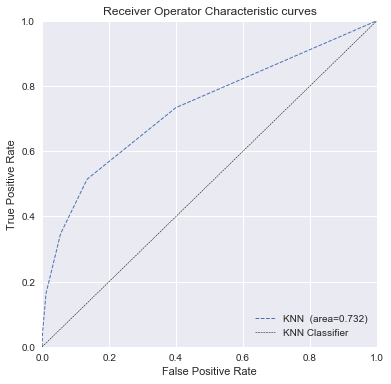

In [442]:
def roc_auc_plot(y_true, y_pred, label=' ', l='-', lw=1.0):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_pred[:,1])
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (area=%.3f)"%(label,roc_auc_score(y_true, y_pred[:,1])))

f, ax = plt.subplots(figsize=(6,6))

roc_auc_plot(ytest,knn.predict_proba(Xtest),label='KNN ',l='--')


ax.plot([0,1], [0,1], color='k', linewidth=0.5, linestyle='--', 
        label='KNN Classifier')    
ax.legend(loc="lower right")    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Receiver Operator Characteristic curves')
sns.despine()
plt.show()


In [443]:
#Area under ROC:Large area under ROC curve the better our model is(AUC)
#Compute AUC
# If the AUC is greater than 0.5, the model is better than random guessing
# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn.predict_proba(Xtest)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(ytest, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(knn, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.7322244057583941
AUC scores computed using 5-fold cross-validation: [ 0.67837327  0.65669262  0.62496915  0.65529672  0.58094976]
